In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sales_train_validation = pd.read_csv('./Walmart Data/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('./Walmart Data/sales_train_evaluation.csv')
sell_prices = pd.read_csv('./Walmart Data/sell_prices.csv')
calendar = pd.read_csv('./Walmart Data/calendar.csv')
sample_submission = pd.read_csv('./Walmart Data/sample_submission.csv')

In [3]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [4]:
calendar['combined_event_type'] = calendar.apply(
    lambda row: row['event_type_1'] if pd.isnull(row['event_type_2'])
    else row['event_type_1'] + ' & ' + row['event_type_2'],
    axis=1
)

In [243]:
'''Data pre-processing'''

'Data pre-processing'

In [5]:
item_category_sales = sales_train_validation.groupby(['item_id', 'cat_id']).sum().iloc[:, -1913:].sum(axis=1).reset_index()

item_category_sales.columns = ['item_id', 'cat_id', 'total_sales']

top_10_per_category = item_category_sales.sort_values(['cat_id', 'total_sales'], ascending=[True, False]).groupby('cat_id').head(10)

sales_train_validation = sales_train_validation.loc[sales_train_validation['item_id'].isin(top_10_per_category['item_id'])]
sales_train_evaluation = sales_train_evaluation.loc[sales_train_evaluation['item_id'].isin(top_10_per_category['item_id'])]

In [6]:
# Melt sales data to long format
sales_train_validation = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_validation['day'] = sales_train_validation['day'].apply(lambda x: x[2:]).astype(int)

data = pd.merge(sales_train_validation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')

data['date'] = pd.to_datetime(data['date'])
data = pd.merge(data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [7]:
#Same for Evaluation Dataset
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_evaluation['day'] = sales_train_evaluation['day'].apply(lambda x: x[2:]).astype(int)
eval_data = pd.merge(sales_train_evaluation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
eval_data['date'] = pd.to_datetime(eval_data['date'])
eval_data = pd.merge(eval_data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [8]:
# Create a list of all the event/holiday columns
event_columns = [col for col in data.columns if 'event' in col]

# Create a new column 'is_event_or_holiday' that is True if any event/holiday is True, False otherwise
data['is_event_or_holiday'] = data[event_columns].any(axis=1)
eval_data['is_event_or_holiday'] = eval_data[event_columns].any(axis=1)

In [9]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = pd.Categorical(data['weekday'], categories=days_order, ordered=True)
eval_data['weekday'] = pd.Categorical(eval_data['weekday'], categories=days_order, ordered=True)

In [10]:
data.sort_values(by=['id', 'date'], inplace=True)
eval_data.sort_values(by=['id', 'date'], inplace=True)

In [ ]:
''' Group and Create Lagged Features
data['sales_lag_1'] = data.groupby(['id'])['sales'].shift(1)
data['sales_lag_7'] = data.groupby(['id'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['id'])['sales'].shift(30)

eval_data['sales_lag_1'] = eval_data.groupby(['id'])['sales'].shift(1)
eval_data['sales_lag_7'] = eval_data.groupby(['id'])['sales'].shift(7)
eval_data['sales_lag_30'] = eval_data.groupby(['id'])['sales'].shift(30)

data['sales_rolling_mean_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
data['sales_rolling_mean_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
data['sales_rolling_std_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
data['sales_rolling_std_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

eval_data['sales_rolling_mean_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
eval_data['sales_rolling_mean_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
eval_data['sales_rolling_std_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
eval_data['sales_rolling_std_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

chunk_size = 100000
num_chunks = len(data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

data = pd.concat(processed_data, ignore_index=True)

chunk_size = 100000
num_chunks = len(eval_data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = eval_data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

eval_data = pd.concat(processed_data, ignore_index=True)

'''

In [11]:
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week
data['start_of_month'] = (data['date'].dt.day == 1).astype(int)
data['is_august'] = (data['month'] == 8).astype(int)
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

In [13]:
eval_data['day_of_week'] = eval_data['date'].dt.dayofweek
eval_data['week_of_year'] = eval_data['date'].dt.isocalendar().week
eval_data['start_of_month'] = (eval_data['date'].dt.day == 1).astype(int)
eval_data['is_august'] = (eval_data['month'] == 8).astype(int)
eval_data['is_weekend'] = (eval_data['day_of_week'] >= 5).astype(int)

In [14]:
data['snap_CA_sales'] = np.where(data['state_id'] == 'CA', data['snap_CA'] * data['sales'], 0)
data['snap_TX_sales'] = np.where(data['state_id'] == 'TX', data['snap_TX'] * data['sales'], 0)
data['snap_WI_sales'] = np.where(data['state_id'] == 'WI', data['snap_WI'] * data['sales'], 0)

In [15]:
eval_data['snap_CA_sales'] = np.where(eval_data['state_id'] == 'CA', eval_data['snap_CA'] * eval_data['sales'], 0)
eval_data['snap_TX_sales'] = np.where(eval_data['state_id'] == 'TX', eval_data['snap_TX'] * eval_data['sales'], 0)
eval_data['snap_WI_sales'] = np.where(eval_data['state_id'] == 'WI', eval_data['snap_WI'] * eval_data['sales'], 0)

In [17]:
data['snap'] = 0

data.loc[data['state_id'] == 'CA', 'snap'] = data['snap_CA']
data.loc[data['state_id'] == 'TX', 'snap'] = data['snap_TX']
data.loc[data['state_id'] == 'WI', 'snap'] = data['snap_WI']

In [18]:
eval_data['snap'] = 0

eval_data.loc[eval_data['state_id'] == 'CA', 'snap'] = eval_data['snap_CA']
eval_data.loc[eval_data['state_id'] == 'TX', 'snap'] = eval_data['snap_TX']
eval_data.loc[eval_data['state_id'] == 'WI', 'snap'] = eval_data['snap_WI']

In [19]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

In [20]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    eval_data[col] = eval_data[col].astype('category').cat.codes

In [264]:
'''Prophet Model'''

'Prophet Model'

In [21]:
eval_data = eval_data.groupby('id').apply(lambda x: x.tail(28))
eval_data.reset_index(drop=True, inplace=True)

In [22]:
holidays = pd.DataFrame({
  'holiday': 'event_or_holiday',
  'ds': data[data['is_event_or_holiday']]['date'],
  'lower_window': 0,  
  'upper_window': 1,  
})


In [23]:
all_predictions = []

all_actuals = []

all_future_forecasts = []

unique_products = data['id'].unique()

for product in unique_products:
    
    product_data = data[data['id'] == product][['date', 'sales', 'snap', 'is_weekend']].rename(columns={'date': 'ds', 'sales': 'y'})
    eval_product_data = eval_data[eval_data['id'] == product][['date', 'sales', 'snap', 'is_weekend']].rename(columns={'date': 'ds', 'sales': 'y'})
    
    nans_count = product_data['y'].isna().sum()
    if nans_count > 0:
        print(f"Product {product} has {nans_count} NaN values in sales data.")
        continue
    
    train = product_data.iloc[:-180]
    valid = product_data.iloc[-180:]
    
    model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.add_seasonality(name='weekly', period=7, fourier_order=3, condition_name='is_weekend')
    model.add_seasonality(name='monthly', period=28, fourier_order=5)
    model.add_regressor('snap')

    model.fit(train)
    
    future = model.make_future_dataframe(periods=180)
    
    future = pd.merge(future, product_data[['ds', 'snap', 'is_weekend']], on='ds', how='left')
    
    forecast = model.predict(future)
    
    predictions = forecast['yhat'][-180:].values
    all_predictions.extend(predictions)
    
    actuals = valid['y'].values
    all_actuals.extend(actuals)

    last_date_in_valid = valid['ds'].max()
    future_28 = model.make_future_dataframe(periods=28, freq='D', include_history=False)
    future_28['ds'] = pd.date_range(start=last_date_in_valid + pd.Timedelta(days=1), periods=28, freq='D')
    
    future_28 = pd.merge(future_28, eval_product_data[['ds', 'snap', 'is_weekend']], on='ds', how='left')
    
    forecast_28 = model.predict(future_28)
    
    future_predictions = forecast_28[['ds', 'yhat']]
    future_predictions['item_id'] = product
    all_future_forecasts.append(future_predictions)

predicted = np.array(all_predictions)
actual = np.array(all_actuals)


all_future_forecasts_df = pd.concat(all_future_forecasts, axis=0, ignore_index=True)

08:48:40 - cmdstanpy - INFO - Chain [1] start processing
08:48:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Brian Silva\AppData\Local\Temp\ipykernel_16840\2322745944.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_predictions['item_id'] = product
08:49:03 - cmdstanpy - INFO - Chain [1] start processing
08:49:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Brian Silva\AppData\Local\Temp\ipykernel_16840\2322745944.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future

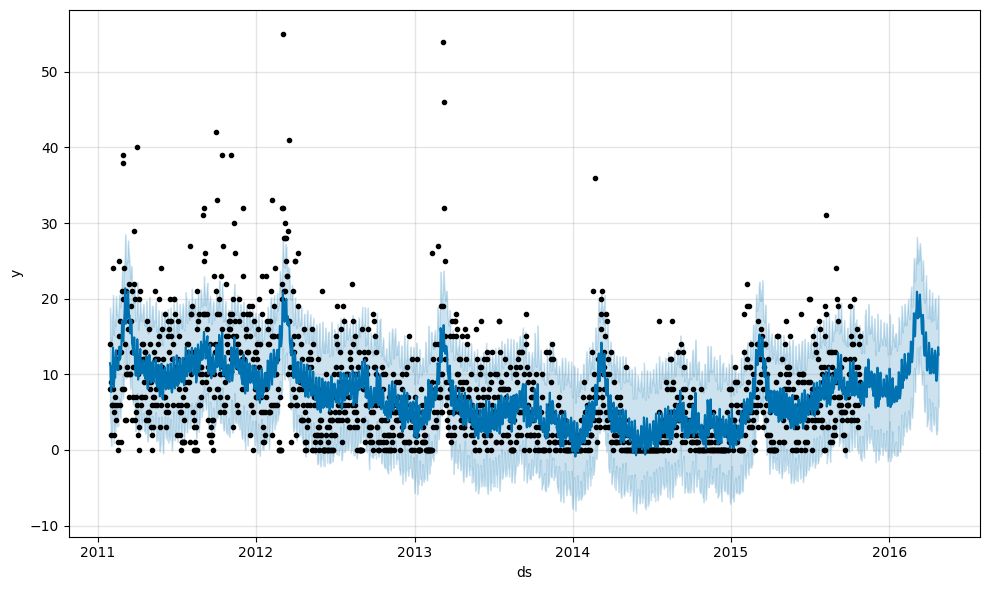

In [34]:
fig = model.plot(forecast)

In [35]:
all_future_forecasts_df['date'] = eval_data['date']
all_future_forecasts_df['actual'] = eval_data['sales']

In [36]:
all_future_forecasts_df

,ds,yhat,item_id,date,actual
0,2016-04-25,23.865259,0,2016-04-25,48
1,2016-04-26,18.940642,0,2016-04-26,35
2,2016-04-27,20.042981,0,2016-04-27,34
3,2016-04-28,23.667728,0,2016-04-28,67
4,2016-04-29,44.877879,0,2016-04-29,63
...,...,...,...,...,...
8395,2016-05-18,8.574407,299,2016-05-18,0
8396,2016-05-19,9.268800,299,2016-05-19,5
8397,2016-05-20,11.398149,299,2016-05-20,9
8398,2016-05-21,12.728285,299,2016-05-21,5


In [37]:
last_180_dates = data['date'].tail(180).values

repeated_dates = np.tile(last_180_dates, data['id'].nunique())

unique_products = eval_data['id'].unique() 
product_ids = np.repeat(unique_products, 180) 

results_df = pd.DataFrame({
    'product_id': product_ids,
    'actual_sales': actual,
    'predicted_sales': predicted,
    'date': repeated_dates
})

results_df.head(180)

,product_id,actual_sales,predicted_sales,date
0,0,40,55.269098,2015-10-28
1,0,58,55.826356,2015-10-29
2,0,77,76.044992,2015-10-30
3,0,101,99.096771,2015-10-31
4,0,58,91.928165,2015-11-01
...,...,...,...,...
175,0,29,23.241688,2016-04-20
176,0,53,27.503570,2016-04-21
177,0,87,49.629467,2016-04-22
178,0,95,66.132860,2016-04-23


In [38]:
mae = mean_absolute_error(actual, predicted)
print('Mean Absolute Error:', mae)

mse = mean_squared_error(actual, predicted)
print('Mean Squared Error:', mse)

mse = mean_squared_error(actual, predicted)
rmse = sqrt(mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 6.071611915056238
Mean Squared Error: 105.96068862433576
Root Mean Squared Error: 10.293720834777664


In [42]:
mae = mean_absolute_error(all_future_forecasts_df['actual'], all_future_forecasts_df['yhat'])
print('Mean Absolute Error:', mae)

mse = mean_squared_error(all_future_forecasts_df['actual'], all_future_forecasts_df['yhat'])
print('Mean Squared Error:', mse)

mse = mean_squared_error(all_future_forecasts_df['actual'], all_future_forecasts_df['yhat'])
rmse = sqrt(mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 6.172744664525003
Mean Squared Error: 97.37820805236339
Root Mean Squared Error: 9.868039726934798


In [39]:
results_df.to_excel('Prophet_results.xlsx')
all_future_forecasts_df.to_excel('Prophet_results_28.xlsx')

In [30]:
grouped_eval_data = data.groupby('date')['sales'].sum().reset_index()
grouped_eval_data.columns = ['date', 'actual_sales']
grouped_predicted_data = results_df.groupby('date')['predicted_sales'].sum().reset_index()

In [31]:
merged_data = pd.merge(grouped_predicted_data, grouped_eval_data, on='date', how='left')

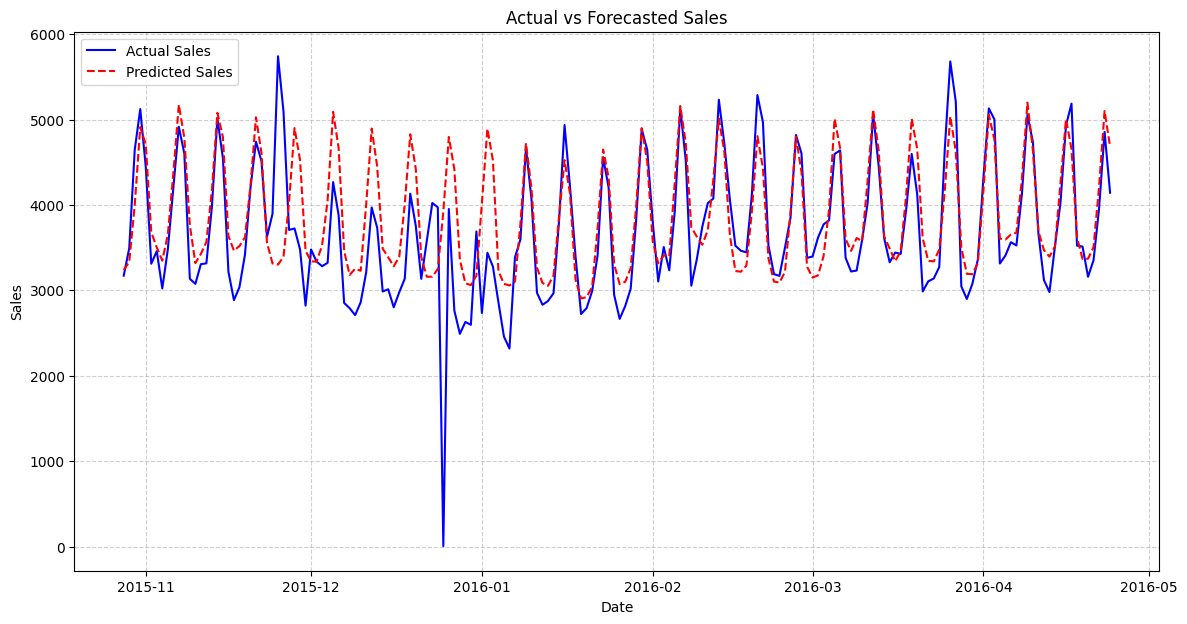

In [40]:
plt.figure(figsize=(14, 7))

# Plot actual sales
plt.plot(merged_data['date'], merged_data['actual_sales'], label='Actual Sales', color='blue')

# Plot predicted sales
plt.plot(merged_data['date'], merged_data['predicted_sales'], label='Predicted Sales', color='red', linestyle='--')

# Customize the plot
plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


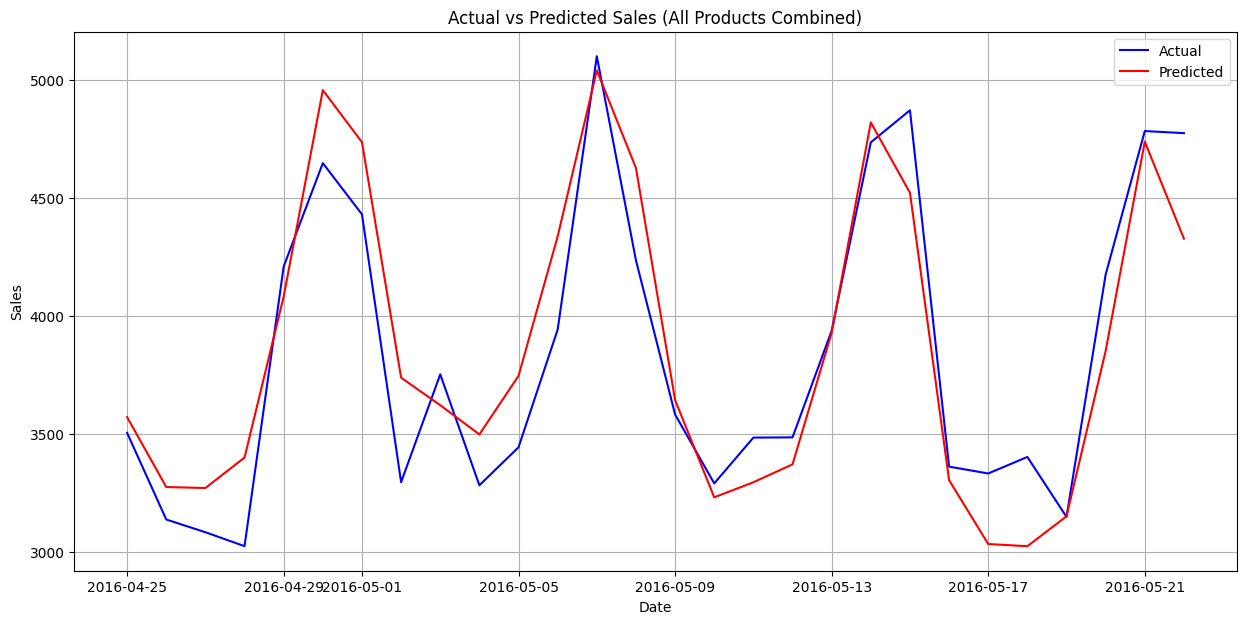

In [41]:
plt.figure(figsize=(15, 7))

# Convert 'date' to datetime
all_future_forecasts_df['date'] = pd.to_datetime(all_future_forecasts_df['date'])

# Group by 'date' and calculate the sum of 'actual_sales' and 'predicted_sales' for all products
grouped = all_future_forecasts_df.groupby('date').agg({
    'actual': 'sum',
    'yhat': 'sum'
}).reset_index()

# Plot the actual values
plt.plot(grouped['date'], grouped['actual'], label='Actual', color='blue')

# Plot the predicted values
plt.plot(grouped['date'], grouped['yhat'], label='Predicted', color='red')

plt.legend()  # Add legend
plt.xlabel('Date')  # Label x-axis
plt.ylabel('Sales')  # Label y-axis
plt.title('Actual vs Predicted Sales (All Products Combined)')  # Add title

# Show the plot
plt.grid(True)
plt.show()